# Make Data
Notebook to make the data for the ESM 203 Ass. 1 Fall 2020 <br>

By Cascade Tuholkse (cascade.tuholske@gmail.com)

In [1]:
#### Dir Paths
PATH = 'data/'

In [2]:
#### Depedencies
import os
from glob import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio 
from rasterstats import zonal_stats


### Merge socioeconomic data

In [3]:
#### Open shape files
neighborhoods_fn = PATH+'la_county/la_county.shp'
neighborhoods = gpd.read_file(neighborhoods_fn)

In [5]:
#### Get socioeconomic data
se_dir = PATH+'socioeconomic/'
fn_out = 'ESM203_F2020_SocioEcon'

# get names 
df_out = neighborhoods[['Name']]
df_out.rename(columns={'Name':'NEIGHBORHOOD'}, inplace=True) # rename col

# loop through files and write out csv
for fn in os.listdir(se_dir):
    
    col = fn.split('LA-')[1].split('.csv')[0] # Get col name
    df = pd.read_csv(se_dir+fn) # open the fn

    if df.shape[1] == 3:
        df_out = df_out.merge(df.iloc[:,1:3], on = 'NEIGHBORHOOD', how = 'left') # merge 
    
    elif df.shape[1] == 4: # crime
        df_out = df_out.merge(df.iloc[:,1:4], on = 'NEIGHBORHOOD', how = 'left') # merge
        df_out.rename(columns = {'PER CAPITA' : "CRIME PER CAPITA"}, inplace = True)
        df_out.rename(columns = {'TOTAL' : "CRIME TOTAL"}, inplace = True)

# write csv
df_out.to_csv(PATH+fn_out+'.csv', index = False)

# write shape file
gdf_out = neighborhoods[['Name','geometry']]
gdf_out.rename(columns={'Name':'NEIGHBORHOOD'}, inplace=True) # rename col
gdf_out = df_out.merge(gdf_out, on = 'NEIGHBORHOOD', how = 'right')
gdf_out = gpd.GeoDataFrame(gdf_out)
gdf_out.to_file(PATH+fn_out+'.shp', index = False)


### Make NDVI and LST from Landsat Scenes
Will do this for two scences one spring and one summer.

In [6]:
def ndvi(b4_fn, b5_fn, out_fn):
    """Funciton writes an NDVI image from Landsat 8. Will throw an error for 0 values in Landsat edges.
    Args:
        b4_fn = path to Landsat8 band 4 (red) geotif
        b5_fn = path to Landsat8 band 5 (NIR) geotif
        fn_out = path and name to write out ndvi file
    """
    
    meta = rasterio.open(b4_fn).meta
    meta.update({'dtype': 'float32'})
    band4 = rasterio.open(b4_fn).read(1) #Red
    band5 = rasterio.open(b5_fn).read(1) #NIR
    
    # NDVI = (NIR — VIS)/(NIR + VIS) 
    ndvi = np.nan_to_num((band5 - band4)/(band5 + band4))
    ndvi = np.float32(ndvi) # reduce size
    
    # write our raster to disk
    with rasterio.open(out_fn, 'w', **meta) as out:
        out.write_band(1, ndvi)

    print('NDVI done')

In [7]:
def bright_temp(b_fn, fn_out, radiance_mult, radiance_add, k1, k2):
    
    """ Function writes a tif for Landsat8 brigthtness temp from DN. Note, this is not land surface tempature.
    Args:
        b_fn = file name for TIRS band
        fn_out = path and file name to write .tif
        radiance_mult, radiance_add, k1, k2 = all come from the Landsat8 Level 1 XXX_MTL.txt file
    """
    # read & meta
    meta = rasterio.open(b_fn).meta
    meta.update({'dtype': 'float32'})
    b = rasterio.open(b_fn).read(1)
    
    # Calculate TOA reflectance from DN:
    toa  = (b * radiance_mult) + radiance_add
    
    # TOA to brightness temp from K to C
    bright = (k2 / np.log(k1 / (toa +1)) - 273.15)
    bright = np.float32(bright)
    
    # Drop Brightness values >50C
    bright[bright >= 50] = np.nan
    
    # write our raster to disk
    with rasterio.open(fn_out, 'w', **meta) as out:
        out.write_band(1, bright)

    print('Brightness temp done')

In [8]:
#### Make NDVI -- Summer 2020-08-20
data_in = PATH+'landsat/Level1/LC08_L1TP_041036_20200820_20200905_01_T1/' 
b4 = data_in+'LC08_L1TP_041036_20200820_20200905_01_T1_B4.TIF'
b5 = data_in+'LC08_L1TP_041036_20200820_20200905_01_T1_B5.TIF'
out = PATH+'interim/NDVI_20200820.tif'
ndvi(b4, b5, out)

/Users/cascade/miniconda3/envs/geo37/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/Users/cascade/miniconda3/envs/geo37/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


NDVI done


In [9]:
#### Make Brightness temp -- Summer 2020-08-20
data_in = PATH+'landsat/Level1/LC08_L1TP_041036_20200820_20200905_01_T1/'
b_fn = data_in+'LC08_L1TP_041036_20200820_20200905_01_T1_B10.TIF'
fn_out = PATH+'interim/BrightTemp_20200820.tif'
radiance_mult = 3.3420E-04
radiance_add = 0.10000
k1 = 774.8853
k2 = 1321.0789
bright_temp(b_fn, fn_out, radiance_mult, radiance_add, k1, k2)

Brightness temp done


In [10]:
#### Make NDVI -- Spring 2020-04-14
data_in = PATH+'landsat/Level1/LC08_L1TP_041036_20200414_20200423_01_T1/' 
b4 = data_in+'LC08_L1TP_041036_20200414_20200423_01_T1_B4.TIF'
b5 = data_in+'LC08_L1TP_041036_20200414_20200423_01_T1_B5.TIF'
out = PATH+'interim/NDVI_20200414.tif'
ndvi(b4, b5, out)

/Users/cascade/miniconda3/envs/geo37/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/Users/cascade/miniconda3/envs/geo37/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


NDVI done


In [11]:
#### Make Brightness temp -- Spring 2020-04-14
data_in = PATH+'landsat/Level1/LC08_L1TP_041036_20200414_20200423_01_T1/'
b_fn = data_in+'LC08_L1TP_041036_20200414_20200423_01_T1_B10.TIF'
fn_out = PATH+'interim/BrightTemp_20200414.tif'
radiance_mult = 3.3420E-04
radiance_add = 0.10000
k1 = 774.8853
k2 = 1321.0789
bright_temp(b_fn, fn_out, radiance_mult, radiance_add, k1, k2)

Brightness temp done


### Run zonal stats

In [12]:
def zonal(rst_in, polys_in, do_stats): 
    """Function will run zonal stats on a raster and a set of polygons. All touched is set to True by default. 
    
    Args:
        rst_in = file name/path of raster to run zonal stats on
        polys = either list of shape files (watersheds) or single shape file (countries)
        do_stats = stats to use, see rasterstats package for documention, (use sume)
    """
    
    # switch crs
    polys_in = polys_in.to_crs({'init' :'epsg:32611'}) # CRS of Landsat tifs
    
    # Run Zonal Stats
    zs_feats = zonal_stats(polys_in, rst_in, stats= do_stats, geojson_out=True, all_touched=True)
        
    # Turn into geo data frame and rename column
    zgdf = gpd.GeoDataFrame.from_features(zs_feats, crs=polys_in.crs)
    
    return zgdf

In [13]:
polys_in =neighborhoods[['Name', 'geometry']]

In [14]:
#### Run Zonal stats - Throws error for Catalina Island which isn't in the scene 
rst_in = PATH+'interim/NDVI_20200414.tif'
ndvi_spring = zonal(rst_in, polys_in, 'mean')
ndvi_spring.rename(columns = {'mean' : 'NDVI_SPRING'}, inplace = True)

rst_in = PATH+'interim/NDVI_20200820.tif'
ndvi_summer = zonal(rst_in, polys_in, 'mean')
ndvi_summer.rename(columns = {'mean' : 'NDVI_SUMMER'}, inplace = True)

rst_in = PATH+'interim/BrightTemp_20200414.tif'
temp_spring = zonal(rst_in, polys_in, 'mean')
temp_spring.rename(columns = {'mean' : 'TEMP_SPRING'}, inplace = True)

rst_in = PATH+'interim/BrightTemp_20200820.tif'
temp_summer = zonal(rst_in, polys_in, 'mean')
temp_summer.rename(columns = {'mean' : 'TEMP_SUMMER'}, inplace = True)


/Users/cascade/miniconda3/envs/geo37/lib/python3.7/site-packages/rasterstats/io.py:300: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


### Merge Final Data

In [15]:
#### Merge it all together
df_list = [ndvi_spring, ndvi_summer, temp_spring, temp_summer]

for df in df_list:
    df.rename(columns = {'Name' : 'NEIGHBORHOOD'}, inplace = True)
    df_out = df_out.merge(df.iloc[:,1:3], on = 'NEIGHBORHOOD', how = 'left')

In [16]:
df_out

,NEIGHBORHOOD,POPULATION PER SQMI,SINGLE PARENTS,ASIAN POPULATION,LATINO POPULATION,WHITE POPULATION,CRIME PER CAPITA,CRIME TOTAL,DIVERSITY INDEX,MEDIAN INCOME,HOMEOWNERS,BLACK POPULATION,NDVI_SPRING,NDVI_SUMMER,TEMP_SPRING,TEMP_SUMMER
0,Acton,166.0,0.09,0.02,0.12,0.82,0.0,0.0,0.316,83983.0,0.88,0.01,0.203897,0.136302,30.096359,49.034277
1,Adams-Normandie,21848.0,0.24,0.05,0.62,0.06,30.3,56.0,0.545,29606.0,0.21,0.25,0.110832,0.088282,38.373948,46.614073
2,Adams-Normandie,21848.0,0.24,0.05,0.62,0.06,29606.0,NaN,0.545,29606.0,0.21,0.25,0.110832,0.088282,38.373948,46.614073
3,Agoura Hills,2495.0,0.10,0.06,0.07,0.83,0.0,0.0,0.304,117608.0,0.84,0.01,0.254858,0.159426,34.428408,46.345871
4,Agua Dulce,99.0,0.05,0.00,0.11,0.84,0.0,0.0,0.282,106078.0,0.87,0.00,0.216954,0.133629,29.226854,48.845687
5,Alhambra,11275.0,0.13,0.47,0.36,0.14,NaN,NaN,0.631,53224.0,0.39,0.01,0.152411,0.124155,37.584622,47.221423
6,Alondra Park,7548.0,0.20,0.15,0.35,0.26,13.9,12.0,0.748,57177.0,0.52,0.19,0.236861,0.178084,36.080845,44.122707
7,Altadena,4900.0,0.13,0.04,0.20,0.40,2.6,11.0,0.702,82676.0,0.75,0.31,0.239067,0.203915,32.672788,44.774268
8,Angeles Crest,3.0,0.07,0.02,0.12,0.72,NaN,NaN,0.452,72841.0,0.88,0.10,inf,0.236501,24.018463,42.581246
9,Arcadia,4749.0,0.10,0.45,0.10,0.40,NaN,NaN,0.620,75808.0,0.62,0.01,0.249555,0.213537,34.988505,45.467095


In [22]:
# Write CSV
fn_out = 'ESM203_F2020_Ass1'
df_out.to_csv(PATH+fn_out+'.csv', index = False)

In [23]:
# Write shape file
gdf_out = neighborhoods[['Name','geometry']]
gdf_out.rename(columns={'Name':'NEIGHBORHOOD'}, inplace=True) # rename col
gdf_out = df_out.merge(gdf_out, on = 'NEIGHBORHOOD', how = 'right')
gdf_out = gpd.GeoDataFrame(gdf_out)
gdf_out.to_file(PATH+fn_out+'.shp', index = False)

/Users/cascade/miniconda3/envs/geo37/lib/python3.7/site-packages/pandas/core/frame.py:4218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


#### Test visualizations

In [24]:
df_out.columns

Index(['NEIGHBORHOOD', 'POPULATION PER SQMI', 'SINGLE PARENTS',
       'ASIAN POPULATION', 'LATINO POPULATION', 'WHITE POPULATION',
       'CRIME PER CAPITA', 'CRIME TOTAL', 'DIVERSITY INDEX', 'MEDIAN INCOME',
       'HOMEOWNERS', 'BLACK POPULATION', 'NDVI_SPRING', 'NDVI_SUMMER',
       'TEMP_SPRING', 'TEMP_SUMMER'],
      dtype='object')

(0, 0.4)

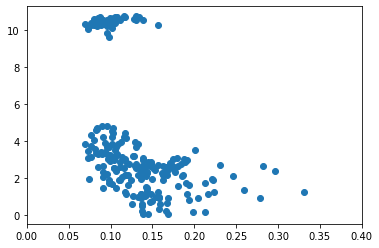

In [28]:
import matplotlib.pyplot as plt
plt.scatter(df_out['NDVI_SUMMER'], np.log(df_out['CRIME PER CAPITA']))
plt.xlim([0,.4])
